In [4]:
import sys; sys.path.append('..'); from wwa import *

Xn, Xx, Yn, Yx = [19,180,41,82]
xn, xx, yn, yx = [105,140,45,70]
map_extent = [19,180,15,82]

mapproj = cartopy.crs.PlateCarree()
mapproj = cartopy.crs.AlbersEqualArea(central_longitude=100)

russia = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.to_geodataframe().set_index("abbrevs").loc[["RUS"]].clip([0,0,180,90]).set_crs(epsg = 4326)

In [5]:
# list locations with known impacts
sites = ["Buryatia", "Zabaikalye", "Khabarovsk", "Sakha-Yakutia"] # removed Novorossiisk - unrelated 
px = pd.DataFrame.from_dict({s : get_latlon(s) for s in sites}).transpose()
px = gpd.GeoDataFrame(px, geometry = gpd.points_from_xy(x=px.lon, y=px.lat), crs = "EPSG:4326")

sites2 = ["Novorossiisk"]
px2 = pd.DataFrame.from_dict({s : get_latlon(s) for s in sites2}).transpose()
px2 = gpd.GeoDataFrame(px2, geometry = gpd.points_from_xy(x=px2.lon, y=px2.lat), crs = "EPSG:4326")

# Spatial extent

## Impacted sites

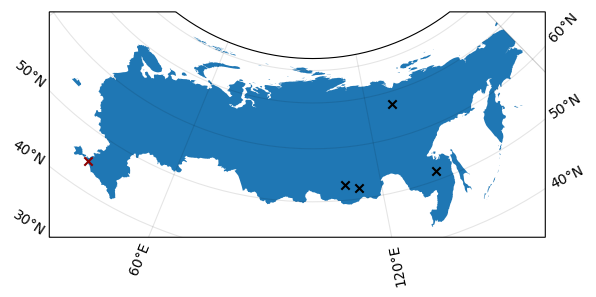

In [49]:
fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj})
russia.to_crs(mapproj).plot(ax = ax)

px.to_crs(mapproj).plot(ax = ax, color = "k", marker = "x")
px2.to_crs(mapproj).plot(ax = ax, color = "darkred", marker = "x")

ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left", "right"])

plt.savefig("fig/impact-sites.png")

## Physical geopgraphy

In [168]:
elev = wrap_lon(xr.open_dataset("../../00_WWA_project_folder/live/data/elev.0.25-deg.nc", decode_times = False).squeeze(drop = True).data).sel(lon = slice(Xn,Xx), lat = slice(Yn,Yx))
kg = wrap_lon(xr.open_dataset("../../00_WWA_project_folder/live/data/koppen-geiger/kg_classifications.nc")).kg_cat.sel(lon = slice(Xn,Xx), lat = slice(Yn,Yx))

# add projected coordinates for neater plotting
elev, kg = [da.assign_coords({k : (["lat", "lon"], v) for k,v in zip(["x","y"], project_latlon(da, to_crs = mapproj))}) for da in [elev, kg]]

# group Koppen-Geiger types for easier interpretation
kg_grouped = xr.apply_ufunc(np.digitize, kg, kwargs={'bins': [0.5,16.5,20.5,24.5,28.5]}).where(kg > 0)

kg_cmap = matplotlib.colors.ListedColormap(['lightgrey', 'tab:blue', 'tab:orange', 'tab:green','skyblue'])

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


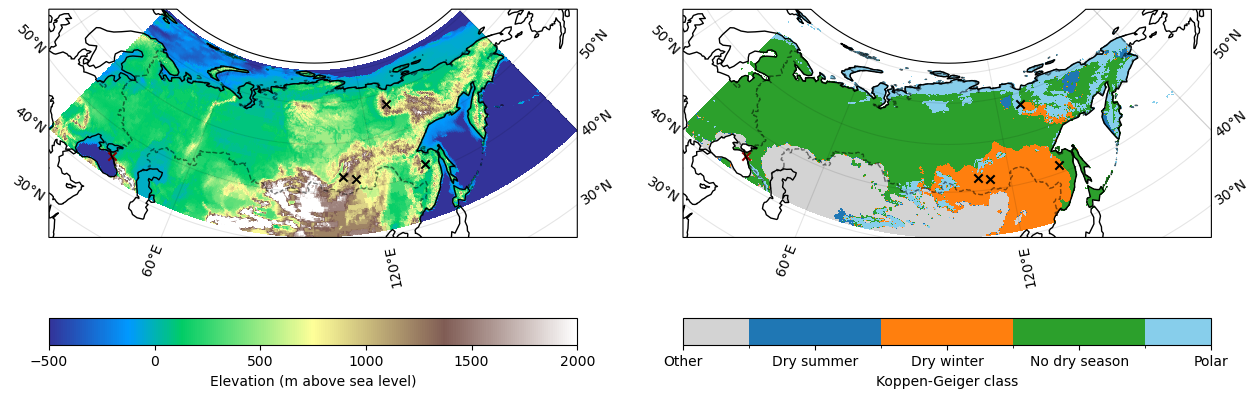

In [192]:
fig, axs = plt.subplots(ncols = 2, figsize = (15,7), dpi = 100, subplot_kw = {"projection" : mapproj})
cbar_kwargs = {"location" : "bottom"}

ax = axs[0]
cbar = ax.pcolormesh(elev.x, elev.y, elev, cmap = "terrain", vmin = -500, vmax = 2000)
plt.colorbar(cbar, ax = ax, label = "Elevation (m above sea level)", **cbar_kwargs)

ax = axs[1]
cbar = ax.contourf(kg.x, kg.y, kg_grouped.where(kg_grouped > 0), cmap = kg_cmap, norm = matplotlib.colors.BoundaryNorm(np.arange(0.5,6.5,1), kg_cmap.N))
cbar = plt.colorbar(cbar, ax = ax, label = "Koppen-Geiger class", **cbar_kwargs, ticks = list(range(1,6)))
cbar.ax.set_xticklabels(["Other", "Dry summer", "Dry winter", "No dry season", "Polar"])

for ax in axs:
    russia.to_crs(mapproj).boundary.plot(ax = ax, color = "k", alpha = 0.5, ls = "--", lw = 1)
    ax.coastlines()
    
    px.to_crs(mapproj).plot(ax = ax, color = "k", marker = "x")
    px2.to_crs(mapproj).plot(ax = ax, color = "darkred", marker = "x")
    
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left", "right"])

plt.savefig("fig/physical-geography.png")

In [186]:
# All type 23 (or very close to the boundary with 23): cold, dry winter, dry summer.
{k : kg.sel(lon = r.lon, lat = r.lat, method = "nearest").values for k, r in px.iterrows()}

{'Buryatia': array(23, dtype=uint8),
 'Zabaikalye': array(23, dtype=uint8),
 'Khabarovsk': array(22, dtype=uint8),
 'Sakha-Yakutia': array(23, dtype=uint8)}

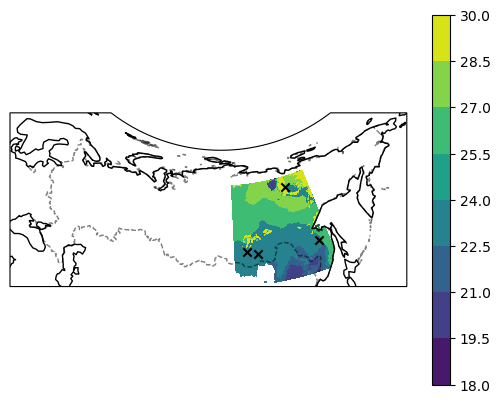

In [196]:
kg_east = kg.sel(lon = slice(105,140), lat = slice(45, 70))

fig, ax = plt.subplots(dpi = 100, subplot_kw = {"projection" : mapproj})

cbar = ax.contourf(kg_east.x, kg_east.y, kg_east.where(kg_east > 16))
plt.colorbar(cbar)
px.to_crs(mapproj).plot(ax = ax, color = "k", marker = "x")

russia.to_crs(mapproj).boundary.plot(ax = ax, color = "k", alpha = 0.5, ls = "--", lw = 1)
ax.coastlines()

# FWI & DSR

## Extract & compile FWI

In [4]:
# Compile FWI data into a single file
fl = sorted(glob.glob("../../00_WWA_project_folder/live/data/era5_fire/*consolidated*.nc"))

fwi_cns = [wrap_lon(xr.open_dataset(fnm)).fwinx.sel(longitude = slice(xn, xx), latitude = slice(yn, yx)).reset_coords(drop = True) for fnm in fl]

int_start = (fwi_cns[-1].time[-1]+1)

fwi_int = wrap_lon(xr.open_dataset("../../00_WWA_project_folder/live/data/era5_fire/era5_025_fwi_intermediate.nc"))
fwi_int = fwi_int.fwinx.sel(longitude = slice(xn, xx), latitude = slice(yn, yx), time = slice(int_start, None)).reset_coords(drop = True)

fwi = xr.concat(fwi_cns + [fwi_int], "time")
fwi = fwi.assign_attrs(note = "Intermediate data after "+str(fwi_int.time.min().values)[:10])

# assign projected coordinates for plotting later
fwi = fwi.to_dataset().assign_coords({k : (["lat", "lon"], v) for k,v in zip(["x","y"], project_latlon(fwi.isel(time = 0, drop = True), to_crs = mapproj))})

fwi.to_netcdf("data/era5_fwi_"+"_".join([str(d) for d in [xn,xx,yn,yx]])+".nc")

## Map of monthly mean DSR

In [ ]:
fwi = xr.open_dataset("data/era5_fwi_105_140_45_70.nc")
dsr = (0.0272 * (fwi.fwi ** 1.71)).rename("dsr")

In [39]:
dsr_m = dsr.sel(time = "2024").resample(time = "MS").mean()

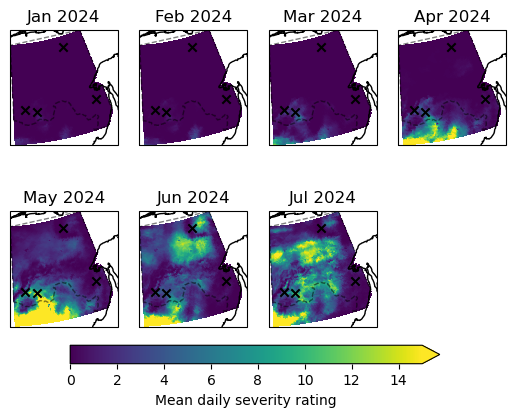

In [65]:
fig, axs = plt.subplots(ncols = 4, nrows = 2, dpi = 100, subplot_kw = {"projection" : mapproj})
cbar_kwargs = {"location" : "bottom"}

for i in range(7):
    ax = fig.axes[i]
    dsr_i = dsr_m.isel(time = i)
    
    cbar = ax.pcolormesh(fwi.x, fwi.y, dsr_i, vmin = 0, vmax = 15)
    
    px.to_crs(mapproj).plot(ax = ax, color = "k", marker = "x")

    russia.clip((xn,yn,xx,yx)).to_crs(mapproj).boundary.plot(ax = ax, color = "k", alpha = 0.5, ls = "--", lw = 1)
    ax.coastlines()
    
    ax.set_title(dsr_i.time.dt.strftime("%b %Y").values)
    
for i in range(7, 8):
    fig.axes[i].set_axis_off()
    
plt.colorbar(cbar, ax = axs, extend = "max", location = "bottom", label = "Mean daily severity rating", fraction = 0.05, pad = 0.05)

plt.savefig("fig/monthly-dsr.png")

# MODIS active fire data

In [1]:
# ! cd data; wget https://firms.modaps.eosdis.nasa.gov/data/download/DL_FIRE_M-C61_489695.zip; unzip data/DL_FIRE_M-C61_489695.zip -d data

In [ ]:
df = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"], index_col = "acq_date") for fnm in glob.glob("data/*M-C61*.csv")])

# filter out low-confidence points
df = df.loc[(df.confidence >= 80), ["latitude", "longitude"]]

df.to_csv("data/modis_conf-80.csv")

In [ ]:
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(x=df.longitude, y=df.latitude), crs = "EPSG:4326")

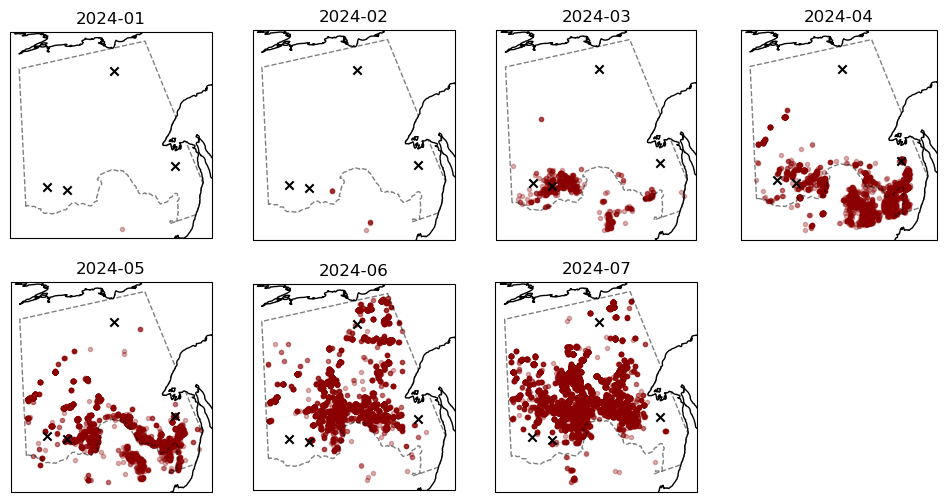

In [15]:
nc = 4; nr = 2

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 3, nr * 3), dpi = 100, subplot_kw = {"projection" : mapproj})
cbar_kwargs = {"location" : "bottom"}

for i in range(7):
    ax = fig.axes[i]
    m = "2024-"+str(i+1).rjust(2,"0")
    px_i = df.loc[m]
    
#     cbar = ax.pcolormesh(fwi.x, fwi.y, dsr_i, vmin = 0, vmax = 15)
    px_i.to_crs(mapproj).plot(ax = ax, color = "darkred", marker = ".", alpha = 0.3)
    px.to_crs(mapproj).plot(ax = ax, color = "k", marker = "x")

    russia.clip((xn,yn,xx,yx)).to_crs(mapproj).boundary.plot(ax = ax, color = "k", alpha = 0.5, ls = "--", lw = 1)
    ax.coastlines()
    
    ax.set_title(m)
    
for i in range(7, 8):
    fig.axes[i].set_axis_off()
    
plt.savefig("fig/monthly-fires.png")

## Cumulative fire activity

In [20]:
# daily fire pixels in the region
px_daily = df.clip(russia.clip((xn,yn,xx,yx))).resample("D").count()[["geometry"]]

In [21]:
days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

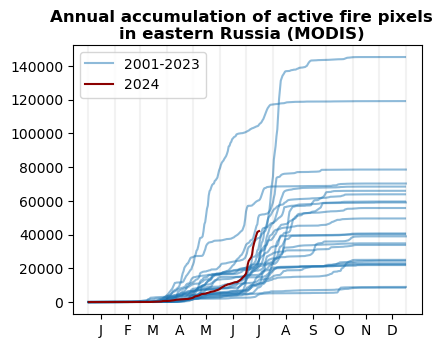

In [24]:
fig, ax = plt.subplots(figsize = (4.5,3.5), dpi = 100)

y = 2001
ts_y = px_daily.loc[str(y)]
ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "tab:blue", alpha = 0.5, label = "2001-2023")

for y in range(2002,2024):
    ts_y = px_daily.loc[str(y)]
    ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "tab:blue", alpha = 0.5, label = "_years")
    
# y = 2020
# ts_y = px_daily.loc[str(y)]
# ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "tab:orange", label = "2020")

y = 2024
ts_y = px_daily.loc[str(y)]
ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "darkred", label = "2024")

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)

[ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]

plt.suptitle("Annual accumulation of active fire pixels\nin eastern Russia (MODIS)", fontweight = "bold")

ax.legend()

plt.savefig("fig/cum_modis-pixels.png")